In [1]:
import cv2
import scipy
import copy
import spatialmath
from scipy.spatial.transform import Rotation
import machinevisiontoolbox as mv
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


def getcube(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x, 0.5)
    y = np.append(y, 0.5)
    z = np.append(z, 0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    Q = cube.reshape(3, -1)  # cube
    Q = np.swapaxes(Q, 0, 1)
    Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
    ones = np.ones(Q.shape[0]).reshape(Q.shape[0], 1)
    Q = np.concatenate((Q, ones), axis=1)
    Q = np.append(np.vstack(
        (x, np.zeros_like(x), np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), y, np.zeros_like(x), np.ones_like(x))).T, Q, axis=0)
    Q = np.append(np.vstack(
        (np.zeros_like(x), np.zeros_like(x), z, np.ones_like(x))).T, Q, axis=0)
    return Q


def projectpoints(K, R, t, Q, printP=False):
    Q.reshape((Q.shape[1], Q.shape[0]))
    T = np.concatenate((R, t), axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i, :]
        projected = P @ p.reshape(4, 1)
        if printP and (Q[i, :] == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
            print(P)
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx, ppsy


DEG2RAD = np.pi / 180

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


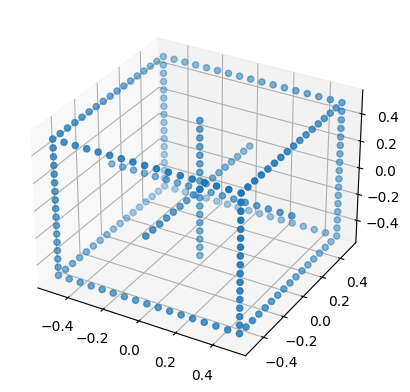

In [2]:
Q = getcube(16)
ax = plt.axes(projection='3d')
ax.scatter3D(Q[:, 0], Q[:, 1], Q[:, 2])

In [3]:
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-2.5) * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
}
cam = mv.CentralCamera(**params)
cam, cam.K
K = cam.K
# cam rotate the camera like here : )
cam.pose = cam.pose * spatialmath.SE3.Rz(-3*DEG2RAD)
cam

           Name: default perspective camera [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 640 x 640
           pose: t = 0, 0, -2.5; rpy/yxz = 0°, 2°, 0°
   principal pt: [320.000 320.000]
   focal length: [0.008 0.008]

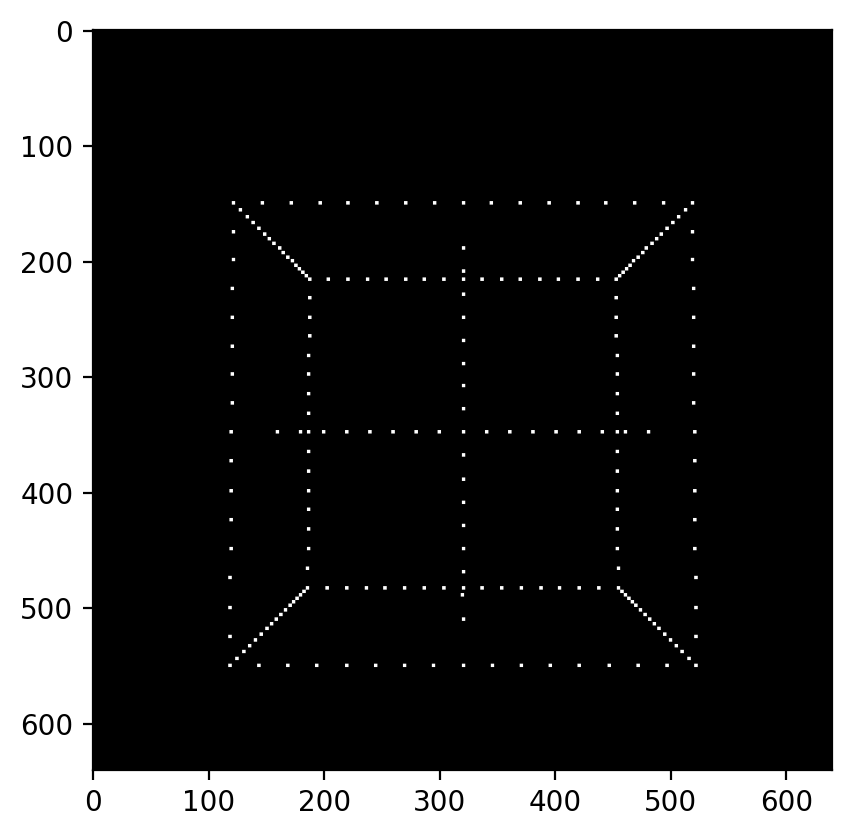

In [4]:
projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
img = np.zeros((640, 640))

for i in range(projected.shape[1]):
    p = projected[:, i]
    if np.isnan(p[0]) or np.isnan(p[1]):
        continue
    u, v = int(p[1]), int(p[0])
    # img[u, v] = 255
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                continue
            img[u+j, v+k] = 255

plt.figure(dpi=200)
plt.imshow(img, cmap='gray')

In [5]:

# Define the vertices of the cube
vertices = [
    [-0.5, -0.5, -0.5],  # 0
    [-0.5, -0.5,  0.5],  # 1
    [-0.5,  0.5, -0.5],  # 2
    [-0.5,  0.5,  0.5],  # 3
    [0.5, -0.5, -0.5],  # 4
    [0.5, -0.5,  0.5],  # 5
    [0.5,  0.5, -0.5],  # 6
    [0.5,  0.5,  0.5],  # 7
]

# Define the center points of each wall
centers = [
    [-0.5, 0, 0],  # Left
    [0.5, 0, 0],  # Right
    [0, -0.5, 0],  # Bottom
    [0, 0.5, 0],  # Top
    [0, 0, -0.5],  # Back
    [0, 0, 0.5],  # Front
]

In [51]:
# https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# randomly select N points
N = int(Q.shape[0]*.5)
rnd_points = np.random.choice(Q.shape[0], N, replace=False)
points_3d = Q[rnd_points][:, :3]
points_3d = np.array(vertices + centers)
N = points_3d.shape[0]

cams = []
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    # * spatialmath.SE3.Rx(2*DEG2RAD) * spatialmath.SE3.Ry(0*DEG2RAD) * spatialmath.SE3.Rz(3*DEG2RAD),
    "pose": spatialmath.SE3.Tz(-3.5)
}
cam = mv.CentralCamera(**params)
cams.append(cam)
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-3.5) * spatialmath.SE3.Tx(.1),
}
cam = mv.CentralCamera(**params)
cams.append(cam)
params = {
    "f": 0.008,
    "rho": 10e-6,
    "imagesize": 640,
    "pp": (320, 320),
    "name": "default perspective camera",
    "pose": spatialmath.SE3.Tz(-3.5) * spatialmath.SE3.Tx(.4),
}
cam = mv.CentralCamera(**params)
cams.append(cam)
# for i in range(3):
#     cams.append(copy.copy(cam))
#     cam.pose = cam.pose * spatialmath.SE3.Tx(-inc) * spatialmath.SE3.Ty(-inc) * spatialmath.SE3.Tz(-inc)
#     # inc += 0.1

camera_ind = np.concatenate((np.zeros(N, dtype=np.uint8), np.ones(
    N, dtype=np.uint8), np.ones(N, dtype=np.uint8)*2))

point_ind = np.concatenate((np.arange(0, N, dtype=np.uint8), np.arange(
    0, N, dtype=np.uint8), np.arange(0, N, dtype=np.uint8)))
point_ind

points_2d = []
for i in range(3):
    projected, _ = cams[i].project_point(points_3d.T, visibility=True)
    points_2d.append(np.array(projected.T))
    # points_2d.append(np.array(projected.T))
points_2d = np.concatenate(points_2d)

In [53]:
points_2d[0], points_2d[N], points_2d[2*N]

(array([186.667, 186.667]),
 array([160.000, 186.667]),
 array([80.000, 186.667]))

In [57]:
points1 = points_2d[:N]
points2 = points_2d[N:N*2]
points3 = points_2d[N*2:]

assert (points1[:, 1] == points2[:, 1]).all()
assert (points2[:, 1] == points3[:, 1]).all()

K = cams[0].K
assert (K == cams[2].K).all()
assert (K == cams[1].K).all()

poses = [(np.eye(3), np.zeros((3, 1)))]
Ps = [K @ np.concatenate((poses[0][0], poses[0][1]), axis=1)]

for i in range(2):
    E, mask = cv2.findEssentialMat(points2, points1, K)
    retval, R, t, mask = cv2.recoverPose(E, points2, points1)
    # accumulate
    R = poses[i][0] @ R
    t = poses[i][1] + poses[i][0] @ t
    poses.append((R, t))
    Ps.append(K @ np.concatenate((R.T, -R.T @ t), axis=1))

# triangulate
for i in range(2):
    if i == 0:
        triang1 = cv2.triangulatePoints(Ps[i], Ps[i+1], points1.T, points2.T)
        triang1 /= triang1[3]
    else:
        triang2 = cv2.triangulatePoints(Ps[i], Ps[i+1], points2.T, points3.T)
        triang2 /= triang2[3]

res = np.linalg.norm(triang1[:3, 1:] - triang1[:3, :-1], axis=0) / \
    np.linalg.norm(triang2[:3, 1:] - triang2[:3, :-1], axis=0)
np.mean(res) # relative scale to the previsous displacement, for instance if first one is .1 and second one is .3
# then this scale is 3

2.9999999999998797

In [33]:
Ps

[array([[800.000, 0.000, 320.000, 0.000],
        [0.000, 800.000, 320.000, 0.000],
        [0.000, 0.000, 1.000, 0.000]]),
 array([[800.000, -0.000, 320.000, -800.000],
        [0.000, 800.000, 320.000, -0.000],
        [0.000, -0.000, 1.000, -0.000]]),
 array([[800.000, -0.000, 320.000, -1600.000],
        [0.000, 800.000, 320.000, -0.000],
        [0.000, -0.000, 1.000, -0.000]])]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6688e+00                                    3.83e-01    
       1              3         1.6685e+00      2.93e-04       1.16e+00       8.20e-01    
       2              5         1.6684e+00      1.11e-04       2.89e-01       1.54e+00    
       3              6         1.6679e+00      4.31e-04       7.22e-02       2.73e-01    
       4              7         1.6679e+00      9.50e-06       1.44e-01       7.19e-02    
       5              8         1.6679e+00      7.48e-07       2.89e-01       1.02e-01    
       6              9         1.6679e+00      3.97e-07       2.89e-01       1.59e-02    
       7             10         1.6679e+00      1.80e-07       7.22e-02       1.18e-03    
       8             11         1.6679e+00      1.56e-09       7.22e-02       4.90e-04    
       9             12         1.6679e+00      1.39e-11       1.81e-02       1.01e-04    

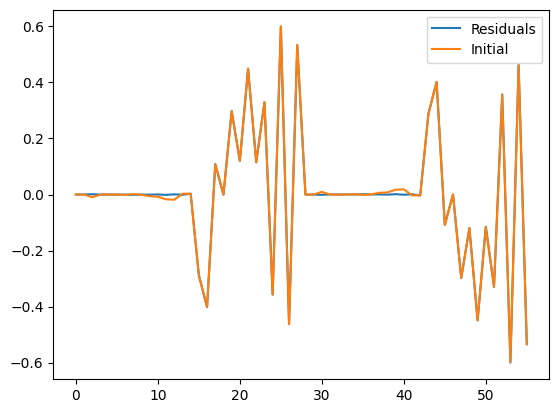

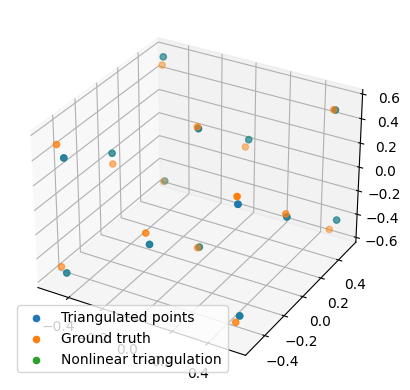

In [186]:
cam0 = cams[0]
cam1 = cams[1]
# wrong : )
# P0 = K @ np.concatenate((cam0.pose.R, cam0.pose.t.reshape((3, 1))), axis=1)
# P1 = K @ np.concatenate((cam1.pose.R, cam1.pose.t.reshape((3, 1))), axis=1)
P0 = cams[0].C()
P1 = cams[1].C()
P0[:,3:] = P0[:,3:] + np.random.rand(3,1)*.01
P1[:,3:] = P1[:,3:] + np.random.rand(3,1)*.01

# Rotation.from_euler('xyz', np.random.rand(3,1).T, degrees=True).as_matrix()

# add some noise
points1 = points1 + np.random.rand(*points1.shape)*2
points2 = points2 + np.random.rand(*points2.shape)*2

triang = cv2.triangulatePoints(P0, P1, points1.T, points2.T)

x0 = (triang/triang[3, :])
P = [P0, P1]
features = [points1.T, points2.T]
org_shape = x0.shape

# this could include feature point aptimization & and refinement of camera poses??
def compute_residuals(Qw):
    Qw = Qw.reshape(org_shape)
    R = []
    for i in range(len(P)):
        inter = P[i] @ Qw
        inter = (inter/inter[2, :])[:2]
        R.append(inter - features[i])
    R = np.array(R)
    R = R.flatten()
    return R


res = scipy.optimize.least_squares(
    compute_residuals, x0.ravel(), verbose=2)
res.x
t = res.x
plt.figure()
plt.plot(res.fun, label='Residuals')
plt.plot(compute_residuals(x0.ravel()), label='Initial')
plt.legend()
t = t.reshape(org_shape)
t /= t[3, :]

# plot 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(triang[0]/triang[3], triang[1]/triang[3],
           triang[2]/triang[3], label='Triangulated points')
ax.scatter(points_3d[:, 0], points_3d[:, 1],
           points_3d[:, 2], label='Ground truth')
ax.scatter(t[0]/t[3], t[1]/t[3], t[2]/t[3], label='Nonlinear triangulation')
ax.legend()

4

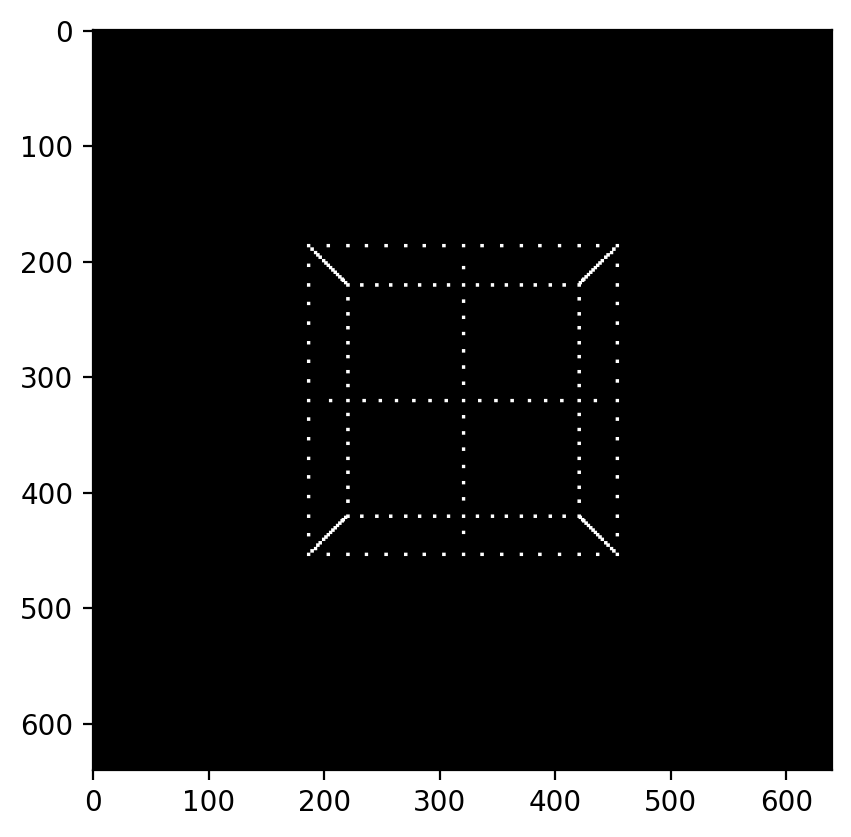

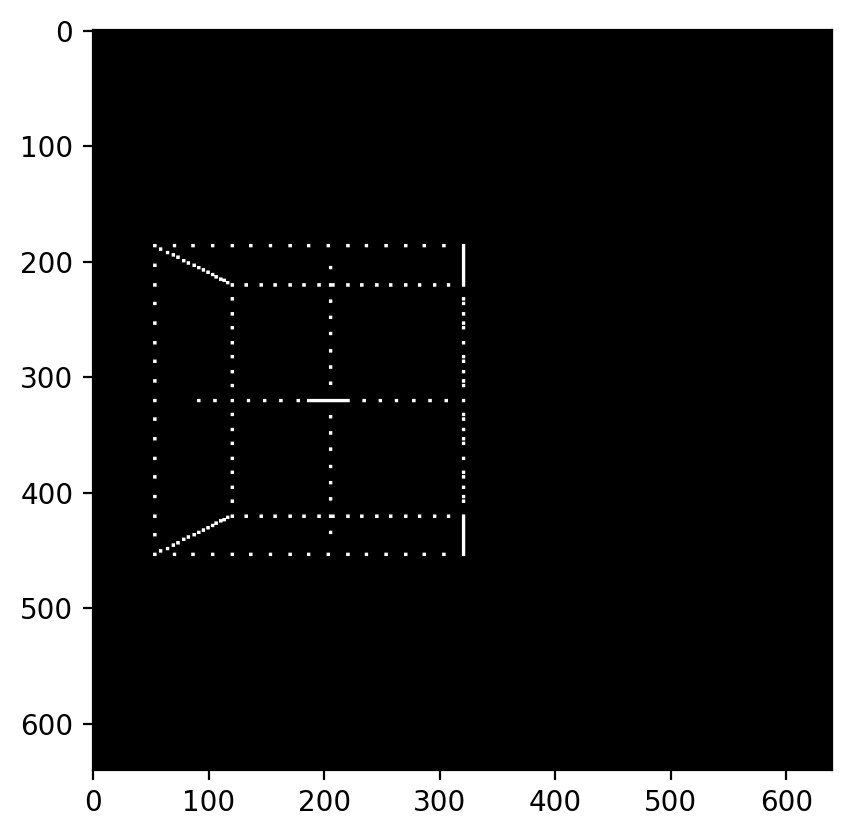

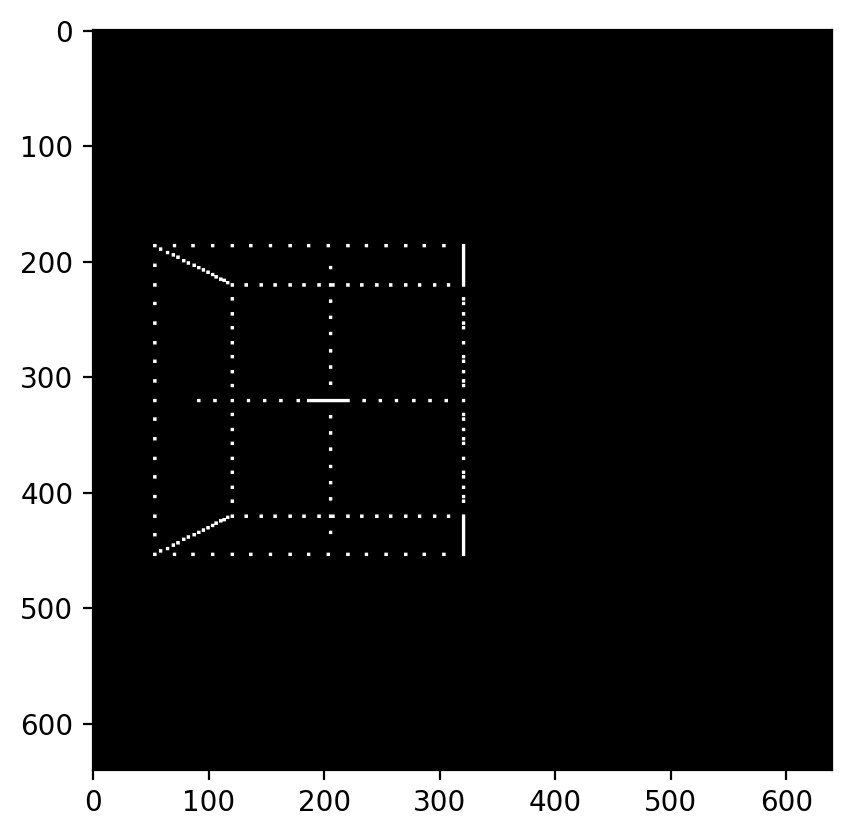

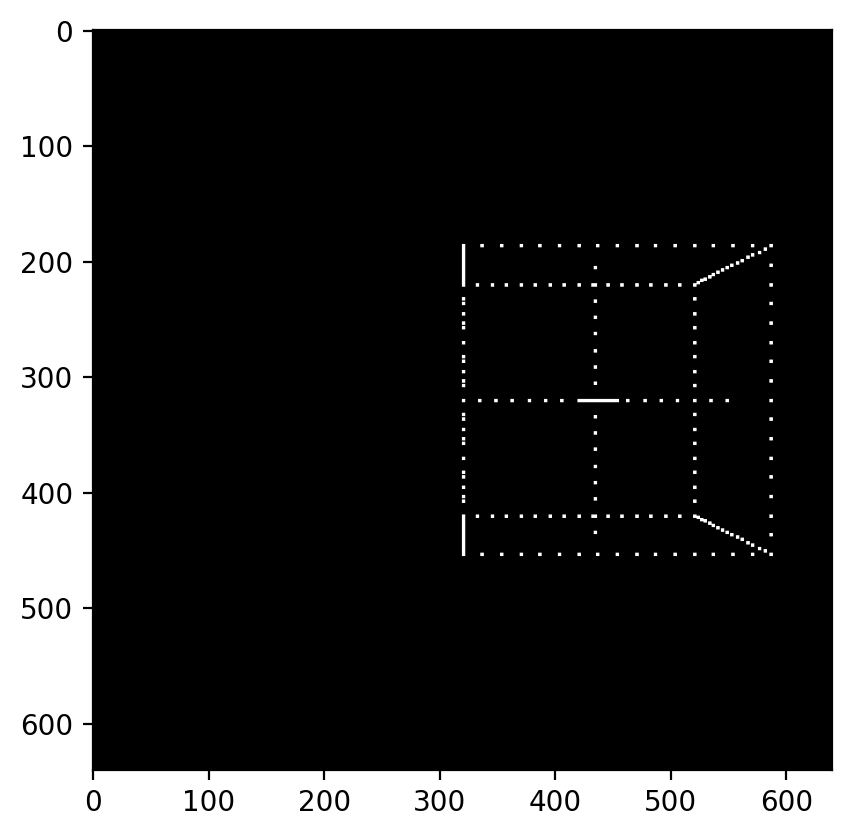

In [273]:
for cam in cams:
    projected, _ = cam.project_point(Q.T[:3, :], visibility=True)
    img = np.zeros((640, 640))

    for i in range(projected.shape[1]):
        p = projected[:, i]
        if np.isnan(p[0]) or np.isnan(p[1]):
            continue
        u, v = int(p[1]), int(p[0])
        # img[u, v] = 255
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                if u+j < 0 or u+j >= 640 or v+k < 0 or v+k >= 640:
                    continue
                img[u+j, v+k] = 255

    plt.figure(dpi=200)
    plt.imshow(img, cmap='gray')

In [11]:
def fun(params, n_cameras, n_points, points_2d):
    """Compute residuals.
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
    points_3d = params[n_cameras * 6:].reshape((n_points, 3))
    points_proj = []
    for i, c in enumerate(cams):
        cam_pose = camera_params[i]
        R = Rotation.from_rotvec(cam_pose[:3]).as_matrix()
        t = cam_pose[3:]
        print(R,t)
        T = np.concatenate((R, t.reshape(3, 1)), axis=1)
        T = np.concatenate((T, np.array([[0, 0, 0, 1]])), axis=0)
        projected, _ = c.project_point(
            points_3d.T, pose=spatialmath.SE3(T), visibility=True)
        points_proj.append(projected.T)
    points_proj = np.concatenate(points_proj)
    return (points_proj - points_2d).ravel()

In [12]:
points_3d

array([[-0.500, -0.500, -0.500],
       [-0.500, -0.500, 0.500],
       [-0.500, 0.500, -0.500],
       [-0.500, 0.500, 0.500],
       [0.500, -0.500, -0.500],
       [0.500, -0.500, 0.500],
       [0.500, 0.500, -0.500],
       [0.500, 0.500, 0.500],
       [-0.500, 0.000, 0.000],
       [0.500, 0.000, 0.000],
       [0.000, -0.500, 0.000],
       [0.000, 0.500, 0.000],
       [0.000, 0.000, -0.500],
       [0.000, 0.000, 0.500]])

In [13]:
camera_params = []
for c in cams:
    R = c.pose.A[:3, :3]  # c.pose.R
    # assert (c.pose.inv().A[:3,:3] == R).all()
    r = Rotation.from_matrix(R)
    rot = r.as_rotvec()
    t = c.pose.A[:3, 3]  # c.pose.t
    print(np.concatenate((rot, t)))
    camera_params.append(np.concatenate((rot, t)))

camera_params = np.concatenate(camera_params)
camera_params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
# add noise
x0[:len(cams)*6] += np.random.randn(len(cams)*6) * .01
x0[len(cams)*6:] += np.random.randn(x0[len(cams)*6:].size) * .01
# x0[len(cams)*6:] = 0*np.abs(np.random.randn(x0[len(cams)*6:].size) * .1)

[0.035 -0.001 0.052 0.000 0.000 -2.500]
[0.035 -0.001 0.052 -0.100 -0.005 -2.500]
[0.035 -0.001 0.052 -0.200 -0.010 -2.500]


In [14]:
euler1 = Rotation.from_rotvec(x0[:3]).as_euler('xyz', degrees=True)
euler2 = Rotation.from_rotvec(camera_params[:3]).as_euler('xyz', degrees=True)
euler1, euler2

(array([1.106, 0.062, 3.306]), array([1.997, -0.105, 2.998]))

[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]


array([-17.516, -14.370, -4.752, -11.829, -13.171, -16.945, -9.061,
       -13.343, -1.340, -12.277, -7.700, -11.767, 2.381, -14.191, -4.588,
       -14.645, -2.223, -13.052, -7.241, -12.186, -13.373, -13.515,
       -8.482, -13.087, -7.372, -17.087, -3.110, -14.382, -13.657, 16.144,
       -3.760, 17.139, -11.976, 16.316, -8.607, 17.117, 0.163, 17.872,
       -7.388, 16.866, 8.553, 17.318, -2.256, 14.761, -0.769, 16.413,
       -4.749, 16.500, -11.734, 15.877, -6.007, 17.790, -4.164, 12.587,
       -1.846, 14.247, -21.870, 6.751, -10.108, 8.085, -21.858, 2.272,
       -15.776, 5.879, -11.996, 10.549, -15.280, 9.097, -7.066, 5.426,
       -12.141, 4.944, -8.550, 6.007, -15.327, 7.674, -20.032, 7.423,
       -16.170, 6.329, -15.649, 2.478, -9.574, 5.018])

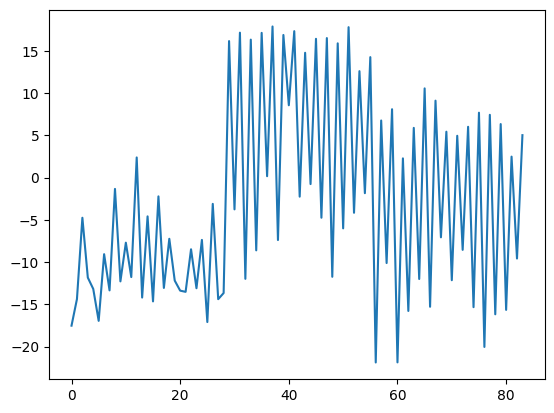

In [15]:
f0 = fun(x0, len(cams), points_3d.shape[0], points_2d)
plt.plot(f0)
f0

In [16]:
from scipy.optimize import least_squares

res = least_squares(fun, x0, verbose=2, x_scale='jac', ftol=1e-4, method='trf',  # , loss='linear',
                    args=(len(cams), points_3d.shape[0], points_2d))

[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]
[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]
[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]
[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.0

[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]
[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]
[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.008]
 [0.055 0.998 -0.043]
 [-0.006 0.043 0.999]] [-0.180 -0.010 -2.509]
[[0.998 -0.058 0.002]
 [0.058 0.998 -0.019]
 [-0.001 0.019 1.000]] [0.009 0.002 -2.494]
[[0.998 -0.060 0.008]
 [0.060 0.997 -0.052]
 [-0.005 0.052 0.999]] [-0.105 -0.013 -2.489]
[[0.998 -0.055 0.0

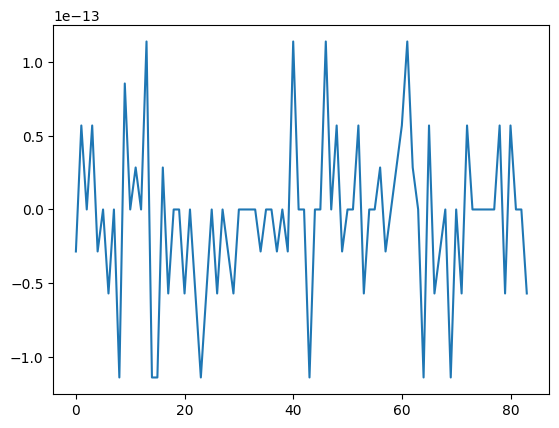

In [17]:
plt.plot(res.fun)

In [18]:
res.x

array([0.045, 0.004, 0.273, -0.008, 0.094, -3.166, 0.045, 0.004, 0.273,
       -0.111, 0.065, -3.166, 0.045, 0.004, 0.273, -0.215, 0.036, -3.166,
       -0.410, -0.570, -1.020, -0.407, -0.581, 0.056, -0.645, 0.480,
       -1.008, -0.643, 0.469, 0.067, 0.640, -0.334, -1.020, 0.642, -0.345,
       0.056, 0.404, 0.715, -1.009, 0.407, 0.705, 0.067, -0.526, -0.050,
       -0.476, 0.523, 0.185, -0.476, 0.116, -0.457, -0.482, -0.119, 0.592,
       -0.471, -0.003, 0.073, -1.014, -0.000, 0.062, 0.062])

In [19]:
camera_params

array([0.035, -0.001, 0.052, 0.000, 0.000, -2.500, 0.035, -0.001, 0.052,
       -0.100, -0.005, -2.500, 0.035, -0.001, 0.052, -0.200, -0.010,
       -2.500])

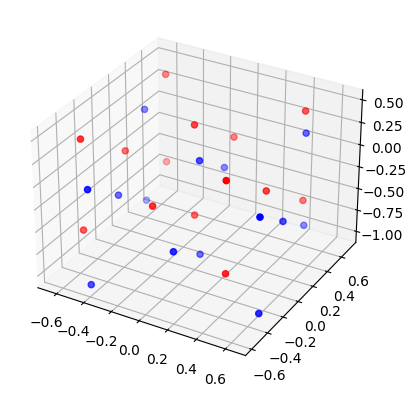

In [20]:
result_3d_points = res.x[len(cams)*6:].reshape((N, 3))
# plot these in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_3d_points[:, 0], result_3d_points[:, 1],
           result_3d_points[:, 2], c='b', marker='o')
# points_3d on top also
ax.scatter(points_3d[:, 0], points_3d[:, 1],
           points_3d[:, 2], c='r', marker='o')

In [21]:
result_3d_points

array([[-0.410, -0.570, -1.020],
       [-0.407, -0.581, 0.056],
       [-0.645, 0.480, -1.008],
       [-0.643, 0.469, 0.067],
       [0.640, -0.334, -1.020],
       [0.642, -0.345, 0.056],
       [0.404, 0.715, -1.009],
       [0.407, 0.705, 0.067],
       [-0.526, -0.050, -0.476],
       [0.523, 0.185, -0.476],
       [0.116, -0.457, -0.482],
       [-0.119, 0.592, -0.471],
       [-0.003, 0.073, -1.014],
       [-0.000, 0.062, 0.062]])

In [22]:
points_3d / result_3d_points

array([[1.220, 0.877, 0.490],
       [1.228, 0.861, 8.884],
       [0.775, 1.042, 0.496],
       [0.778, 1.066, 7.428],
       [0.781, 1.496, 0.490],
       [0.778, 1.449, 8.892],
       [1.237, 0.699, 0.496],
       [1.229, 0.710, 7.433],
       [0.950, -0.000, -0.000],
       [0.955, 0.000, -0.000],
       [0.000, 1.093, -0.000],
       [-0.000, 0.844, -0.000],
       [-0.000, 0.000, 0.493],
       [-0.000, 0.000, 8.094]])